In [1]:
#-------
#IMPORTS
#-------

import numpy as np
import time
from scipy.integrate import odeint
from pylab import *
import scipy.constants as const
from numba import double
from numba.decorators import jit, autojit
from scipy.constants import m_e,c,e, epsilon_0, h, alpha, hbar
import matplotlib.pyplot as plt
from pylab import title, show

In [19]:
#------------------
#INITIAL PARAMETERS
#------------------

#LASER
a0 = 1.2 #Max laser amplitude
w0 = 35.e-6 #Laser waist
ctau = 14.e-6 #Laser duration
z0 = 0.e-6 #Focus position
zf = 500.e-6 #Laser focus
lambda_0 = 800.e-9 #laser wavelength
RMS = 1 #RMS of the gaussian laser profile
E_max = 2 

#GAS
energy = 0e3 #initial energy of the ionized electrons (in eV)
element = 'Ar' # Element that is used fo ionization injection (string, use the shortcut, f.e. 'N' for nitrogen)
n0 = 1.e24 #Plasma density
gaussian_gas_profile = False #True: Gaussian gas density with FWHM = gas_FWHM or False: constant gas density
gas_FWHM = 300e-6 #FWHM of the gas density distribution (just for gaussian_gas_profile = True)

#PLOT SETTINGS
ion_niveau = 8 #The niveau that should get ionized 	
iterations = 1.2e4 #Resolution of the plots (the higher the better)

In [74]:
# Density distribution
def n(zz,gaussian_gas_profile):  
    if gaussian_gas_profile == False:
        return n0 * ones(zz.size)
    else:
        sigma = gas_FWHM/(np.sqrt(2*np.log(2)))
        return n0 * np.exp(-zz**2/(sigma**2)) * ones(zz.size)

# Plasma frequency
def omega_p(zz,gaussian_gas_profile): 
    return sqrt(n(zz,gaussian_gas_profile)*e**2/(epsilon_0*m_e))

# Initial electric field of the plasma in V/m
def E_0(zz):
    return c*m_e*omega_p(zz,gaussian_gas_profile)/e 

# Normalized plasma phase velocity
def beta_p(zz,gaussian_gas_profile):
    return 1-omega_p(zz,gaussian_gas_profile)**2/(2*omega_0**2)
    
# Plasma wave phase velocity
def gamma_p(zz, gaussian_gas_profile):
    return np.sqrt(1/(1-beta_p(zz, gaussian_gas_profile)**2))

# Plasma wavenumber
def k_p(zz, gaussian_gas_profile): 
    return omega_p(zz, gaussian_gas_profile)/c

In [75]:
#----------------------
#INITIALIZE OUTPUT LIST
#----------------------

output_list = ['Ionization induced trapping - outputs\n-----------------------------\n']
output_list.append('Element: '+str(element)+'')
output_list.append('Ionization level: '+str(element)+str(ion_niveau)+'+ -> '+str(element)+str(ion_niveau+1)+'+')
output_list.append('Max laser amplitude a0: '+str(a0)+'\n')

In [76]:
#----------
#INFO TEXTS
#----------

print('\n------------------------------\nCALCULATIONS STARTED\n')

#--------------
#LASER PROFILES
#--------------

#Envelope
def a(psi,a0,RMS):
    return a0*np.exp(-psi**2/(4*RMS**2))

#Oscillating field
def gaussian_profile(max_a, z, r, t, w0, ctau, z0, zf, k_0):

    # Calculate the Rayleigh length

    zr = 0.5*k_0*w0**2
    inv_zr = 1./zr
    inv_ctau2 = 1./ctau**2
    
    
    # Diffraction and stretch_factor
    diffract_factor = 1. - 1j*(z-zf)*inv_zr
    stretch_factor = 1.
    # Calculate the argument of the complex exponential
    exp_argument = 1j*k_0*( c*t + z0 - z )         - r**2 / (w0**2 * diffract_factor)         - 1./stretch_factor * inv_ctau2 * ( c*t  + z0 - z )**2
    # Get the transverse profile
    profile_Eperp = np.exp(exp_argument)         / ( diffract_factor * stretch_factor**0.5 )
    
    return(max_a*profile_Eperp.real )


------------------------------
CALCULATIONS STARTED



In [77]:
#------------------
#IONIZATION PROCESS
#------------------

#IONIZATION PROBABILITY
def ion_prob(psi):
    
    E_gauss = gaussian_profile(a0, psi,0,0,w0,ctau,z0,zf,k_0) 
    
    amplitude = a(psi,a0, RMS)

	#Keldysh parameter
    gamma_k = (alpha/amplitude)*np.sqrt(U_i/U_H) 
    
	#Calculate the electrical field of the laser (in V/m)
    E_L = 1e2*np.sqrt(2.8e18/(lambda_0*1e6*c*epsilon_0))*E_gauss #Electrical field of the laser in V/m
	
    #Argument of the exponential function
    laser_ion = lambda_0/lambda_c * amplitude**3 *gamma_k**3 * (E_k/(np.sqrt(E_L**2)))
    tunnel_ion = (gamma_k**3 * energy)/(hbar*omega_0)
    
    #Probability
    prob = np.exp(-2/3 * (laser_ion + tunnel_ion))
    
    return(prob)

#IONIZATION DEGREE
def degree(psi,info):
	n = np.zeros_like(psi+1)
	print(info)
	#start_timer_2 = time.time()
	for i,val in enumerate(psi):
		sys.stdout.write("\r" + " > Current status:" + str("% .1f" % (i/len(psi)*100)) +"%")
		prob = ion_prob(val)
		if i+1 < len(psi):
			n[i+1]=  n[i]+prob*(n0-n[i])
		sys.stdout.flush()
	print()
	#end_timer_2 = time.time()
	#print("This process took "+str(int((end_timer_2-start_timer_2)/60))+" min, "+str(int(((end_timer_2-start_timer_2)/60)-int((end_timer_2-start_timer_2)/60))*60)+" sec!\n")
	if info == "Calculating ionization degree...":
		output_list.append('- Max. ionization degree: '+ str(n[len(psi)-1]/n0 *100) +'%')
		output_list.append('- Max. ionization probability: '+ str(ion_prob(psi[int(len(psi)/2)])*100)+'%')
		print('- Max. ionization degree: '+ str(n[len(psi)-1]/n0 *100) +'%')
		print('- Max. ionization probability: '+ str(ion_prob(psi[int(len(psi)/2)])*100)+'%\n')
	return n/n0


#IONIZATION ENERGIES
if element == 'N':
	U_G = [14.534,29.600,47.449,77.473,97.890,552.070,667.045]
elif element == 'Ar':
	U_G = [15.760,27.629,40.742,59.812,75.017,91.009,124.319,143.462,422.448,478.684,	538.963,618.260,686.104,755.742,854.772,918.026,4120.887,4426.228]
elif element == 'Kr':
	U_G = [14.000,24.360,26.949,52.547,64.673,78.458,111.001,125.802,230.854,268.227,307.819,350.312,390.733,446.700,492.303,541.015,591.800,640.512,785.612,833.287,884.072,936.930,998.079,1050.937,1151.471,1205.261,2927,907,3069.897,3227.434,3380.826]
else:
	print("Choose an available element for ionization injection")
    
U_i = U_G[ion_niveau]


In [78]:
#----------------------------------
#QUASI STATIC PLASMA WAVE EEQUATION          
#----------------------------------
          
# Potential (PSI DEPENDENCE)
def potentialeq(phi,psi,z,zi,gaussian_gas_profile):
    return array([phi[1],gamma_p(z,gaussian_gas_profile)[zi]**2 * (beta_p(z,gaussian_gas_profile)[zi]*(np.sqrt(1/(1 - (1+ a(psi,a0,RMS)**2)/(gamma_p(z,gaussian_gas_profile)[zi]**2 * (1+phi[0])**2))))-1)])

# Phi min
def get_phi_min(E_max,z,gaussian_gas_profile):
    return (-1+1/(2*gamma_p(z,gaussian_gas_profile)**2))*(1-1/E_max**2) + E_max**2/(4*gamma_p(z,gaussian_gas_profile)**2)

In [83]:
#-----
#PLOTS
#-----

fig, ax = plt.subplots(figsize=(20,10))


psi = np.linspace(-2*np.pi,2*np.pi,iterations)
z = np.linspace(0, 1000, iterations)
    
# Initial conditions
phiinit = array([0,0]) 

start_timer_1 = time.time()

print("Calculating the wakefield potential, this may take a moment...")    
# Solve the quasi static plasma wave equation
phi = list(map(lambda x: odeint(potentialeq, phiinit, psi, args = (z,x,gaussian_gas_profile,)),range(10)))
end_timer_1 = time.time()
print("Finished - This process took "+str(int((end_timer_1-start_timer_1)/60))+" min, "+str(int((((end_timer_1-start_timer_1)/60)-int((end_timer_1-start_timer_1)/60))*60))+" sec!\n")

# Plot of the solution
ax.plot(psi/np.pi,phi[3][:,0], linestyle='--', label="$a_0 =$ "+str("%.1f" % a0)+"")
ax.plot(psi/np.pi, n(psi/1e5,False)/1e24)

/home/sebastian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/sebastian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


Calculating the wakefield potential, this may take a moment...
Finished - This process took 0 min, 2 sec!



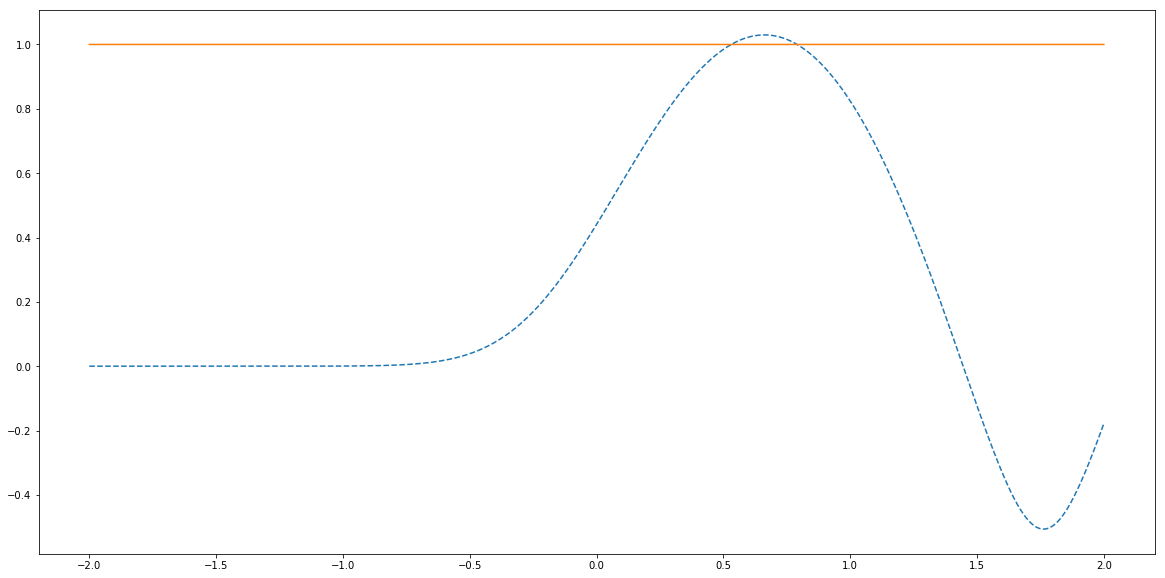

In [84]:
plt.show()

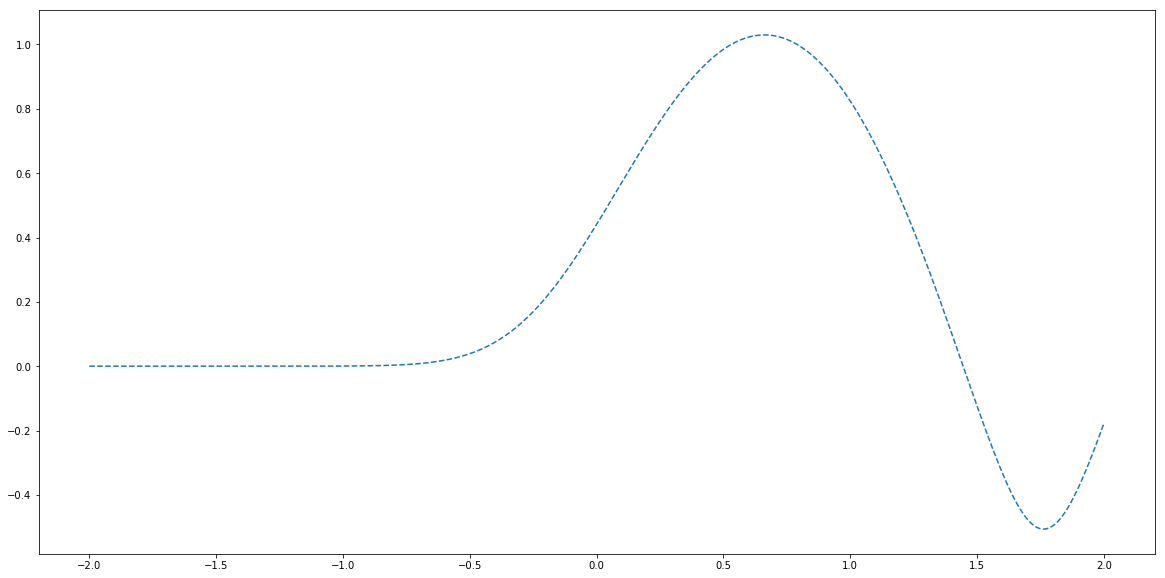

In [27]:
plt.show()